# Tutorial 1: data integration for mouse spleen SPOTS

In this tutorial, we demonstrate how to apply SpatialGlue to integrate SPOTS (Chetrit et al.) data to decipher tissue heterogeity at a higher resolution. SPOTS enables the simultaneous measurements of spatial transcriptomics and protein profiling. As a example, we analyse a mouse spleen dataset. We downloaded the data from the GEO repository (accession no. GSE198353, https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE198353). According to marker genes and proteins, we manually annotated the tissue to 5 cell types, including T cell, B cell, RpMØ(red pulp macrophage), MZMØ(marginal zone macrophage ), and MMMØ(marginal metallophilic macrophages). Please refer to the results below for more details.

It's important to note that the SpatialGlue model is based on PyTorch framework and might exhibit slight sensitivity to random seed or GPU enviroment. However, with larger input data (referring to the number of spots), the impact of these variations dimished. Furthermore, under consistent implementation enviroments, SpatialGlue yields reproducible results. 

Before running the model, please download the input data via https://drive.google.com/drive/folders/1pV6u6U3JD8aTnBIGHEZdctZ0hZfWcBY1.

## Loading package

In [40]:
import os
import torch
import pandas as pd
import scanpy as sc

In [41]:
from SpatialGlue import SpatialGlue

In [42]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# the location of R, which is required for the 'mclust' algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = '/scbio4/tools/R/R-4.0.3_openblas/R-4.0.3'

# fix random seed
#from SpatialGlue.preprocess import fix_seed
#random_seed=2022
#fix_seed(random_seed)

In [43]:
# the number of clusters
n_clusters = 5

## Loading data

In [44]:
# read data
file_fold = '/home/yahui/anaconda3/work/SpatialGlue_revision/data/Dataset1_Mouse_Spleen1/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_Pro.h5ad') 

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

/home/yahui/anaconda3/envs/STGAT/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Pre-processing data
After reading data of two omics modalities, SpatialGlue pre-processes the data as inputs of the model, including expression feature pre-processing and neighbor graph construction. More details can be found in the paper. (https://www.biorxiv.org/content/10.1101/2023.04.26.538404v2) 

The pre-processed features will be saved in adata_omics1.obsm['feat'] and adata_omics2.obsm['feat'] for modalities 1 and 2 respectively. 

In [45]:
from SpatialGlue.preprocess import preprocessing
data = preprocessing(adata_omics1, adata_omics2, datatype='SPOTS')

In [46]:
# flip tissue image 
import numpy as np
adata_omics1.obsm['spatial'] = np.rot90(np.rot90(np.rot90(np.array(adata_omics1.obsm['spatial'])).T).T).T
adata_omics1.obsm['spatial'][:,1] = -1*adata_omics1.obsm['spatial'][:,1]

## Training the model

The SpatialGlue model aims to learn an integrated latent representation by adaptively integrating expression profiles of different omics modalities in a spatially aware manner. 

After model training, SpatialGlue returns 'output' file. The 'output' file include multiple output results. Let's go through each of the results in more detail:

1. Latent Representations:

* 'emb_latent_omics1': latent representation for the first omics modality.

* 'emb_latent_omics2': latent representation for the second omics modality.

* 'SpatialGlue': joint representation learned by incorporating expression data and spatial location information.

   The joint representation can be used for downstream analysis such as clustering, visualization, or identifying differentially expressed genes (DEGs).

2. Attention Weight Values:

* 'alpha_omics1': intra-modality attention weight for the first omics modality, explaining the contribution of each graph to each cluster.

* 'alpha_omics2': intra-modality attention weight for the second omics modality, explaining the contribution of each graph to each cluster.

* 'alpha': inter-modality attention weight explaining the contribution of each modality to each cluster.

   These intra- and inter-modality attention weights provide interpretable insights into the importance of each neighborhood graph and modality to each cluster. 

In [47]:
# define model
model = SpatialGlue.SpatialGlue(data, datatype='SPOTS', device=device)

# train model
output = model.train()

  0%|                                                                                                                                                                                 | 0/600 [00:00<?, ?it/s]/home/yahui/anaconda3/envs/STGAT/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/yahui/anaconda3/envs/STGAT/lib/python3.8/site-packages/SpatialGlue/model.py:150: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:14<00:00, 41.31it/s]


Model training finished!



In [50]:
adata_combined = adata_omics1.copy()
adata_combined.obsm['emb_latent_omics1'] = output['emb_latent_omics1'].copy()
adata_combined.obsm['emb_latent_omics2'] = output['emb_latent_omics2'].copy()
adata_combined.obsm['SpatialGlue'] = output['SpatialGlue'].copy()

## Cross-omics integrative analysis

After integration, we perform clustering analysis using the joint representation. Here we provid three optional kinds of tools for clustering, including mclust, leiden, and louvain. In our experiment, we find 'mclust' algorithm performs better than 'leiden' and 'louvain' on spatial data in most cases. Therefore, we recommend using 'mclust' algorithm for clustering.

In [51]:
# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
tool = 'mclust' # mclust, leiden, and louvain
clustering(adata_combined, key='SpatialGlue', add_key='SpatialGlue', n_clusters=5, method=tool, use_pca=True) 

fitting ...
  |======================================================================| 100%


/home/yahui/anaconda3/envs/STGAT/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yahui/anaconda3/envs/STGAT/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


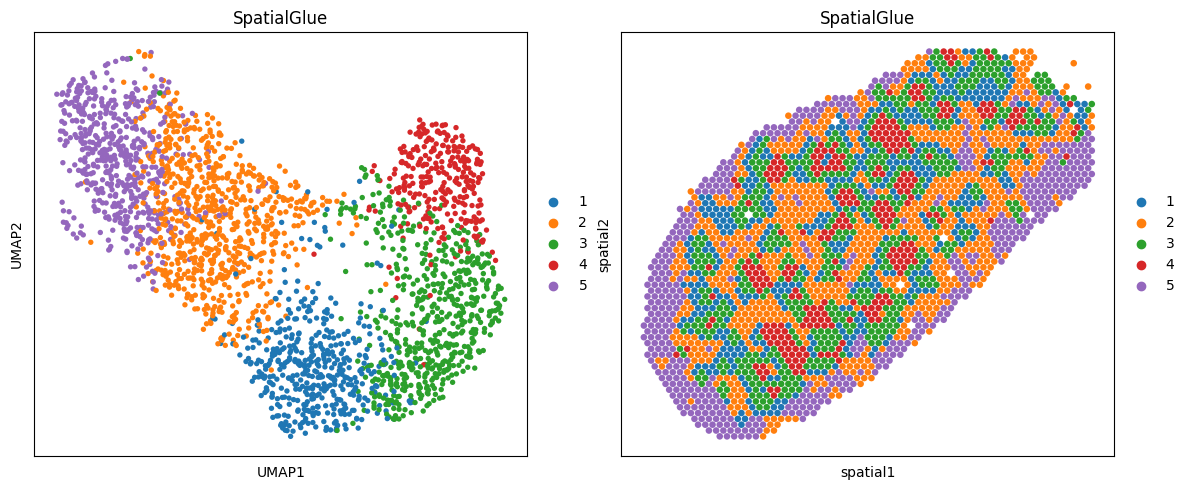

In [52]:
# visualization

fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(adata_combined, use_rep='SpatialGlue', n_neighbors=10)
sc.tl.umap(adata_combined)

sc.pl.umap(adata_combined, color='SpatialGlue', ax=ax_list[0], title='SpatialGlue', s=60, show=False)
sc.pl.embedding(adata_combined, basis='spatial', color='SpatialGlue', ax=ax_list[1], title='SpatialGlue', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

In [53]:
# annotation
# 'MZMØ' represents marginal zone macrophage, 'MMMØ' represents marginal metallophilic macrophages, 'RpMØ' represents red pulp macrophage
adata_combined.obs['SpatialGlue'].cat.rename_categories({1: 'MMMØ',
                                                   2: 'MZMØ',
                                                   3: 'B cell',
                                                   4: 'T cell',
                                                   5: 'RpMØ'
                                                   }, inplace=True)

/tmp/ipykernel_90317/1451384291.py:3: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  adata_combined.obs['SpatialGlue'].cat.rename_categories({1: 'MMMØ',


In [54]:
# reorder
import pandas as pd
list_ = ['MZMØ','MMMØ','RpMØ','B cell', 'T cell']
adata_combined.obs['SpatialGlue']  = pd.Categorical(adata_combined.obs['SpatialGlue'], 
                      categories=list_,
                      ordered=True)

/home/yahui/anaconda3/envs/STGAT/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yahui/anaconda3/envs/STGAT/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


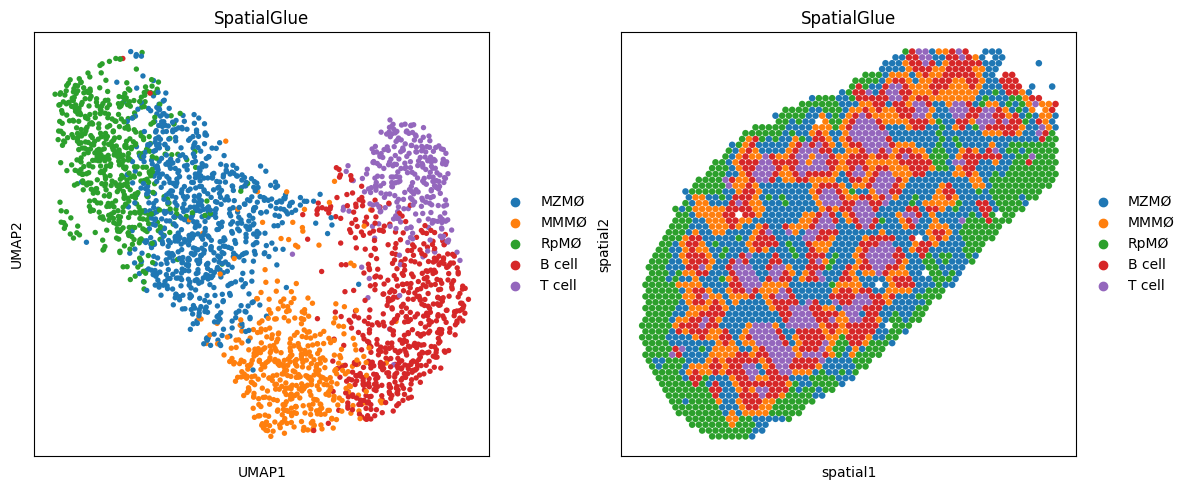

In [55]:
# plotting with annotation
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))

sc.pl.umap(adata_combined, color='SpatialGlue', ax=ax_list[0], title='SpatialGlue', s=60, show=False)
sc.pl.embedding(adata_combined, basis='spatial', color='SpatialGlue', ax=ax_list[1], title='SpatialGlue', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

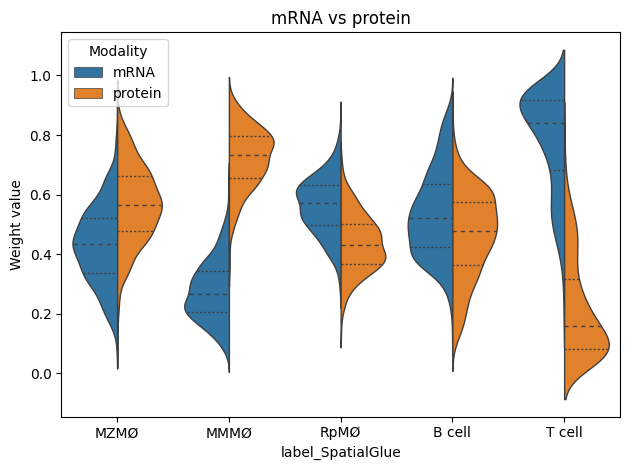

In [56]:
# plotting modality weight values
# To visualize the weight values of different modalities, we provide 'plot_weight_value' function. 
from SpatialGlue.utils import plot_weight_value
plot_weight_value(output['alpha'], adata_combined.obs['SpatialGlue'].values)